In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
import matplotlib.pyplot as plt

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image.float()
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
annotations_file = '/kaggle/input/food-and-beverage-labels/labels_(train).csv'
train_data_dir = '/kaggle/input/food-and-beverage-labels/train'
test_data_dir = '/kaggle/input/food-and-beverage-labels/test'

data = pd.read_csv(annotations_file)
data

,image_name,label
0,0000.png,0
1,0001.png,1
2,0002.png,1
3,0003.png,1
4,0004.png,0
...,...,...
2171,2171.png,1
2172,2172.png,1
2173,2173.png,1
2174,2174.png,0


In [11]:
train_size, val_size = 1700, 476

train_val_data = CustomImageDataset(annotations_file, train_data_dir)
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])

Sample Number: 906
Feature batch shape: torch.Size([3, 512, 512])
Labels batch shape: 0


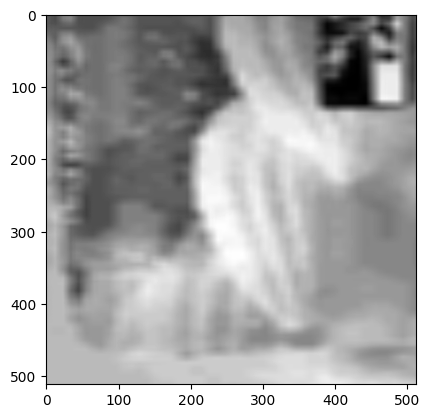

Label: 0


In [12]:
import random

sample_train_num = random.randint(1, train_size)

# Display image and label.
train_features, train_labels = train_data.__getitem__(sample_train_num)

print(f"Sample Number: {sample_train_num}")
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0].squeeze()
label = train_labels
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

Sample Number: 98
Feature batch shape: torch.Size([3, 512, 512])
Labels batch shape: 0


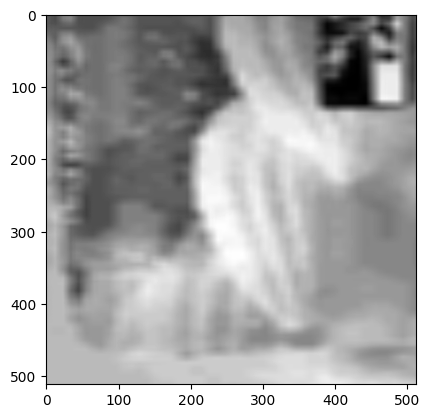

Label: 0


In [13]:
import random

sample_val_num = random.randint(1, 176)

# Display image and label.
val_features, val_labels = val_data.__getitem__(sample_val_num)

print(f"Sample Number: {sample_val_num}")
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels}")
img = train_features[0].squeeze()
label = train_labels
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [14]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=64, shuffle=True)
train_dataloader.__dict__

{'dataset': <torch.utils.data.dataset.Subset at 0x7bfcc54e2ef0>,
 'num_workers': 0,
 'prefetch_factor': None,
 'pin_memory': False,
 'pin_memory_device': '',
 'timeout': 0,
 'worker_init_fn': None,
 '_DataLoader__multiprocessing_context': None,
 '_dataset_kind': 0,
 'batch_size': 64,
 'drop_last': False,
 'sampler': <torch.utils.data.sampler.RandomSampler at 0x7bfcc443b4f0>,
 'batch_sampler': <torch.utils.data.sampler.BatchSampler at 0x7bfcc4439a20>,
 'generator': None,
 'collate_fn': <function torch.utils.data._utils.collate.default_collate(batch)>,
 'persistent_workers': False,
 '_DataLoader__initialized': True,
 '_IterableDataset_len_called': None,
 '_iterator': None}

In [15]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 3, 512, 512])
Labels batch shape: torch.Size([64])


In [16]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [17]:
import torch.nn as nn
import torch.nn.functional as F


class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 127 * 127, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(2, 2), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=258064, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [18]:
logits = model(train_features)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


In [19]:
learning_rate = 1e-2
batch_size = 64
epochs = 5

In [20]:
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

In [21]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [23]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(val_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.477190  [   64/ 1700]
loss: 20.445810  [  704/ 1700]
loss: 0.722402  [ 1344/ 1700]
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.712980 

Epoch 2
-------------------------------
loss: 0.703668  [   64/ 1700]
loss: 0.693006  [  704/ 1700]
loss: 0.695486  [ 1344/ 1700]
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.690623 

Epoch 3
-------------------------------
loss: 0.685569  [   64/ 1700]
loss: 0.696570  [  704/ 1700]
loss: 0.710586  [ 1344/ 1700]
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.693593 

Epoch 4
-------------------------------
loss: 0.725546  [   64/ 1700]
loss: 0.738802  [  704/ 1700]
loss: 0.698278  [ 1344/ 1700]
Test Error: 
 Accuracy: 54.6%, Avg loss: 0.821803 

Epoch 5
-------------------------------
loss: 0.843082  [   64/ 1700]
loss: 0.688774  [  704/ 1700]
loss: 0.701380  [ 1344/ 1700]
Test Error: 
 Accuracy: 45.4%, Avg loss: 0.715032 

Done!
